In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


In [2]:
df = pd.read_csv('../data/data_cleaned.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head(2)

country          region  year  happiness_score  \
0  Switzerland  Western Europe  2015            7.587   
1      Iceland  Western Europe  2015            7.561   

   economy_(gdp_per_capita)   family  health_(life_expectancy)  freedom  \
0                   1.39651  1.34951                   0.94143  0.66557   
1                   1.30232  1.40223                   0.94784  0.62877   

   trust_(government_corruption)  generosity  dystopia_residual  \
0                        0.41978     0.29678            2.51738   
1                        0.14145     0.43630            2.70201   

   food_supply_(kcal/capita/day)  \
0                         3460.0   
1                         3548.0   

   crude_birth_rate_(births_per_1,000_population)  \
0                                          10.364   
1                                          12.933   

   deaths_-_unsafe_water_source_per_100k_people  \
0                                      0.030155   
1                                      0.021300   

   deaths_-_conflict_and_terrorism  
0                              0.0  
1                              0.0

In [3]:
X = df.drop(columns=['happiness_score', 'region', 'country'])
y = df['happiness_score']

In [4]:
X

year  economy_(gdp_per_capita)    family  health_(life_expectancy)  \
0    2015                  1.396510  1.349510                  0.941430   
1    2015                  1.302320  1.402230                  0.947840   
2    2015                  1.325480  1.360580                  0.874640   
3    2015                  1.459000  1.330950                  0.885210   
4    2015                  1.326290  1.322610                  0.905630   
..    ...                       ...       ...                       ...   
465  2017                  0.368746  0.945707                  0.326425   
466  2016                  0.747190  0.148660                  0.629940   
467  2017                  0.511136  1.041990                  0.364509   
468  2017                  0.777153  0.396103                  0.500533   
469  2017                  0.000000  0.000000                  0.018773   

      freedom  trust_(government_corruption)  generosity  dystopia_residual  \
0    0.665570                       0.419780    0.296780           2.517380   
1    0.628770                       0.141450    0.436300           2.702010   
2    0.649380                       0.483570    0.341390           2.492040   
3    0.669730                       0.365030    0.346990           2.465310   
4    0.632970                       0.329570    0.458110           2.451760   
..        ...                            ...         ...                ...   
465  0.581844                       0.252756    0.455220           0.540061   
466  0.069120                       0.172330    0.483970           0.817890   
467  0.390018                       0.354256    0.066035           0.621130   
468  0.081539                       0.493664    0.151347           1.061574   
469  0.270842                       0.280876    0.056565           2.066005   

     food_supply_(kcal/capita/day)  \
0                      3460.000000   
1                      3548.000000   
2                      3315.000000   
3                      3435.000000   
4                      3438.000000   
..                             ...   
465                    2215.000000   
466                    3136.093023   
467                    2396.000000   
468                    3136.093023   
469                    1758.000000   

     crude_birth_rate_(births_per_1,000_population)  \
0                                            10.364   
1                                            12.933   
2                                            10.411   
3                                            11.397   
4                                            10.710   
..                                              ...   
465                                          32.062   
466                                          24.525   
467                                          37.075   
468                                          24.115   
469                                          35.660   

     deaths_-_unsafe_water_source_per_100k_people  \
0                                        0.030155   
1                                        0.021300   
2                                        0.071516   
3                                        0.065375   
4                                        0.068045   
..                                            ...   
465                                     40.604192   
466                                      0.230011   
467                                     40.963010   
468                                      0.226669   
469                                    150.308479   

     deaths_-_conflict_and_terrorism  
0                           0.000000  
1                           0.000000  
2                           0.035288  
3                           0.000000  
4                           0.000000  
..                               ...  
465                         0.031862  
466                       308.409636  
467                         0.079669  
468       

In [5]:
y

0      7.587
1      7.561
2      7.527
3      7.522
4      7.427
       ...  
465    3.471
466    3.069
467    3.349
468    3.462
469    2.693
Name: happiness_score, Length: 470, dtype: float64

In [6]:
pf = PolynomialFeatures(include_bias=False)
X_poly = pf.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state=42)


In [8]:
ss = StandardScaler()
ss.fit(X_train, y_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [9]:
X_train.shape

(352, 90)

In [14]:
def model_func(layer_one_neurons, layer_two_neurons, dropout_percent):
    print('layer_one', layer_one_neurons, 'layer_two', layer_two_neurons) # only to help troubleshoot
    model = Sequential()
    model.add(Dense(layer_one_neurons, activation='relu', input_shape=(90,)))
    model.add(Dropout(dropout_percent))
    model.add(Dense(layer_two_neurons, activation='relu'))
    model.add(Dropout(dropout_percent))
    model.add(Dense(1, activation=None))
    model.compile(loss='mse', optimizer='adam')
    return model

nn = KerasRegressor(build_fn=model_func, batch_size=8, verbose=0)

params = {
    'epochs': [50, 75, 100],
    'layer_one_neurons': [32, 64, 128],
    'layer_two_neurons': [32, 64, 128],
    'dropout_percent': [.25, .5]
}
gs = GridSearchCV(nn, param_grid=params, cv=5)
gs.fit(X_train_sc, y_train)
print(gs.best_score_) # <- negative mean squared error, ie the higher (less negative) the better
gs.best_params_

<ipython-input-14-3a86a3836cf3>:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  nn = KerasRegressor(build_fn=model_func, batch_size=8, verbose=0)


layer_one 32 layer_two 32
layer_one 32 layer_two 32
layer_one 32 layer_two 32
layer_one 32 layer_two 32
layer_one 32 layer_two 32
layer_one 32 layer_two 64
layer_one 32 layer_two 64
layer_one 32 layer_two 64
layer_one 32 layer_two 64
layer_one 32 layer_two 64
layer_one 32 layer_two 128
layer_one 32 layer_two 128
layer_one 32 layer_two 128
layer_one 32 layer_two 128
layer_one 32 layer_two 128
layer_one 64 layer_two 32
layer_one 64 layer_two 32
layer_one 64 layer_two 32
layer_one 64 layer_two 32
layer_one 64 layer_two 32
layer_one 64 layer_two 64
layer_one 64 layer_two 64
layer_one 64 layer_two 64
layer_one 64 layer_two 64
layer_one 64 layer_two 64
layer_one 64 layer_two 128
layer_one 64 layer_two 128
layer_one 64 layer_two 128
layer_one 64 layer_two 128
layer_one 64 layer_two 128
layer_one 128 layer_two 32
layer_one 128 layer_two 32
layer_one 128 layer_two 32
layer_one 128 layer_two 32
layer_one 128 layer_two 32
layer_one 128 layer_two 64
layer_one 128 layer_two 64
layer_one 128 layer_t

{'dropout_percent': 0.25,
 'epochs': 100,
 'layer_one_neurons': 32,
 'layer_two_neurons': 32}

0.9408125613676266

In [10]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(90,)))
model2.add(Dropout(0.25))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(1, activation=None))
model2.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])

history = model2.fit(X_train_sc, y_train, batch_size=8, epochs=100,
                     verbose=0, validation_data=(X_test_sc, y_test))

In [11]:
preds = model2.predict(X_test_sc)

In [12]:
from sklearn.metrics import r2_score
r2_score(y_test, model2.predict(X_test_sc))

0.9541983332485524

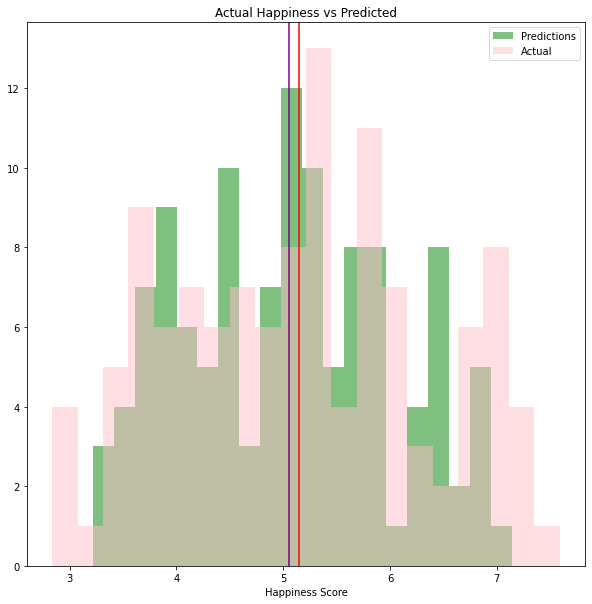

In [15]:
plt.figure(figsize=(10,10))
plt.hist(preds, color="green", alpha=0.5, bins=20, label="Predictions")
plt.hist(y_test, color="pink", alpha=0.5, bins=20, label="Actual");
plt.axvline(y_test.mean(), color='red')
plt.axvline(preds.mean(), color='purple')
plt.title('Actual Happiness vs Predicted')
plt.xlabel('Happiness Score')
plt.legend()
plt.savefig('../visuals/nnr_preds_vs_actual.png')
plt.show();

In [14]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                5824      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,273
Trainable params: 14,273
Non-trainable params: 0
_________________________________________________________________


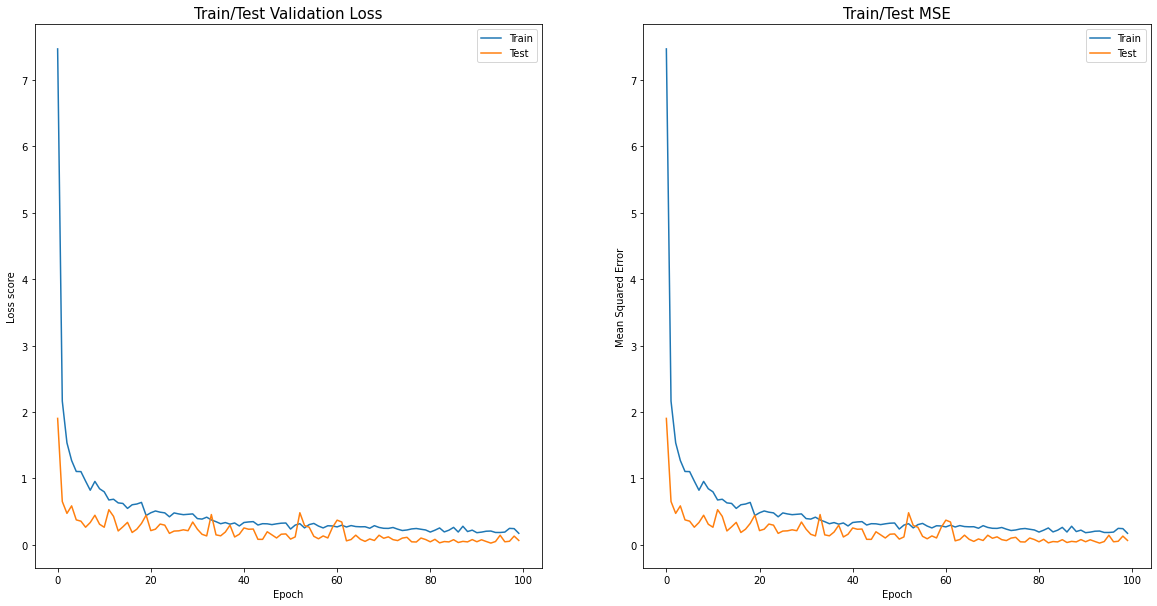

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Test')
ax1.set_title('Train/Test Validation Loss', size=15)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss score')
ax1.legend();

ax2.plot(history.history['mean_squared_error'], label='Train')
ax2.plot(history.history['val_mean_squared_error'], label='Test')
ax2.set_title('Train/Test MSE', size=15)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Squared Error')
ax2.legend()
plt.savefig('../visuals/loss_and_mse.png');